# Autoencoder

Using TensorFlow

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [23]:
from tensorflow.keras import backend as K 

In [3]:
# Load fashion-mnist dataset
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
(60000, 28, 28)
(10000, 28, 28)


In [5]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim 

    # Encoder definition
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    # Decoder definition
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


In [6]:
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [7]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0402 - val_loss: 0.0133
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0123 - val_loss: 0.0105
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0102 - val_loss: 0.0098
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0095 - val_loss: 0.0093
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0092 - val_loss: 0.0093
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0089 - val_loss: 0.0091
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 999us/step - loss: 0.0089 - val_loss: 0.0089
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0087 - val_loss: 0.0089


In [8]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

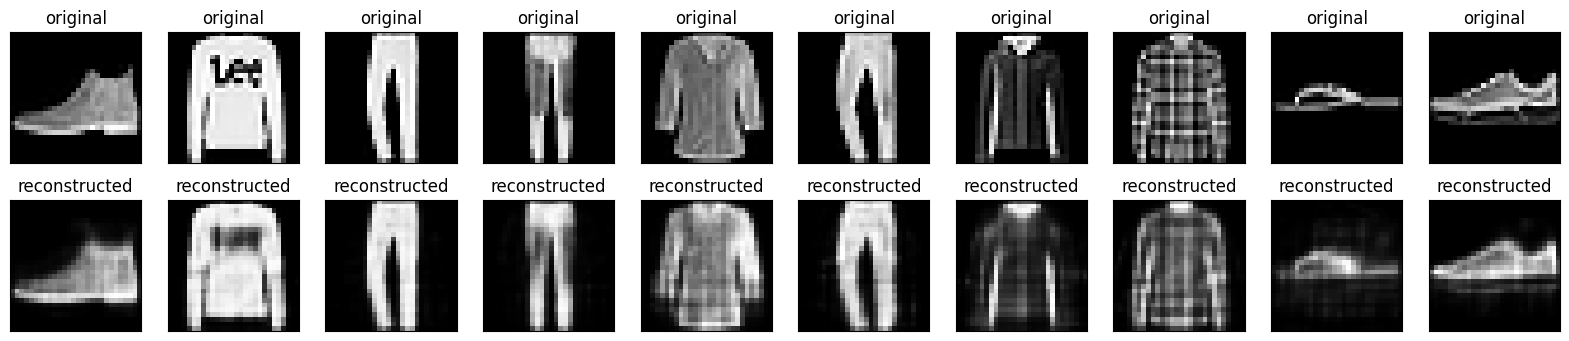

In [9]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

---

# Variational Autoencoder

In [82]:
def encoder(latent_dim):
    input_ = layers.Input(shape=[28,28], name='input')
    flat = layers.Flatten(name='flat')(input_)
    dense1 = layers.Dense(latent_dim, activation='relu',name='dense1')(flat)
    dense2 = layers.Dense(latent_dim, activation='relu',name='dense2')(dense1)
    
    flat2= layers.Flatten()(dense2)
    mean = layers.Dense(2, name='mean')(flat2)
    log_var = layers.Dense(2, name='log_var')(flat2)   
    return tf.keras.models.Model(inputs=[input_], outputs=[mean, log_var], name='V_encoder')

def sampling():
    mean = layers.Input(shape=[2], name='input_layer1')
    log_var = layers.Input(shape=[2], name='input_layer2')
    out = layers.Lambda(sampling_reparameterization, name='sampling_output')([mean, log_var])
    return tf.keras.models.Model([mean, log_var], out,  name="Sampling")

def sampling_reparameterization(distribution_params):
    mean, log_var = distribution_params
    epsilon = K.random_normal(shape=K.shape(mean), mean=0., stddev=1.)
    z = mean + K.exp(log_var / 2) * epsilon
    return z

def decoder(latent_dim):
    input_ = layers.Input(shape=[2],name='input')
    dense1 = layers.Dense(latent_dim, activation='relu',name='dense1')(input_)
    dense2 = layers.Dense(latent_dim, activation='relu',name='dense2')(dense1)
    dense3 = layers.Dense(784, activation='sigmoid',name='dense3')(dense2)
    output = layers.Reshape((28, 28))(dense3)
    return tf.keras.models.Model(inputs=[input_], outputs=[output], name='V_decoder')


In [89]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)
 
def mse_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2])
    return 1000 * r_loss
 
def kl_loss(mean, log_var):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis = 1)
    return kl_loss
 
def vae_loss(y_true, y_pred, mean, log_var):
    r_loss = mse_loss(y_true, y_pred)
    kl_loss_ = kl_loss(mean, log_var)
    return  r_loss + kl_loss_

In [99]:
latent_dim=64
enc = encoder(latent_dim)
dec = decoder(latent_dim)
sam = sampling()
epochs=30
enc_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005)
dec_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005)


for e in range(epochs):

    with tf.GradientTape() as encoder_grad, tf.GradientTape() as decoder_grad:
        
        mean, log_var = enc(x_train, training=True)
        latent = sam([mean, log_var])
        generated_images = dec(latent, training=True)
        loss = vae_loss(x_train, generated_images, mean, log_var)

    gradients_of_enc = encoder_grad.gradient(loss, enc.trainable_variables)
    gradients_of_dec = decoder_grad.gradient(loss, dec.trainable_variables)
     
    enc_optimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
    dec_optimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))

    print("Step: {}".format(enc_optimizer.iterations.numpy()))
    print(tf.math.reduce_mean(loss))
    # print(f"Training Loss: {loss}")
    # print("Training Loss: {}, Accuracy: {}".format(loss(label_train, model2(data_train)).numpy(), accuracy(label_train, model2(data_train)).numpy()))
    # print("Val Loss: {}, Accuracy: {}".format(loss(label_test, model2(data_test)).numpy(), accuracy(label_test, model2(data_test)).numpy()))
        

Step: 1
tf.Tensor(170.93631, shape=(), dtype=float32)
Step: 2
tf.Tensor(168.70287, shape=(), dtype=float32)
Step: 3
tf.Tensor(163.98727, shape=(), dtype=float32)
Step: 4
tf.Tensor(155.26227, shape=(), dtype=float32)
Step: 5
tf.Tensor(144.9788, shape=(), dtype=float32)
Step: 6
tf.Tensor(132.6251, shape=(), dtype=float32)
Step: 7
tf.Tensor(120.69365, shape=(), dtype=float32)
Step: 8
tf.Tensor(111.11713, shape=(), dtype=float32)
Step: 9
tf.Tensor(104.59303, shape=(), dtype=float32)
Step: 10
tf.Tensor(100.02944, shape=(), dtype=float32)
Step: 11
tf.Tensor(96.92564, shape=(), dtype=float32)
Step: 12
tf.Tensor(94.660385, shape=(), dtype=float32)
Step: 13
tf.Tensor(92.31707, shape=(), dtype=float32)
Step: 14
tf.Tensor(90.69959, shape=(), dtype=float32)
Step: 15
tf.Tensor(89.00087, shape=(), dtype=float32)
Step: 16
tf.Tensor(87.09634, shape=(), dtype=float32)
Step: 17
tf.Tensor(85.52438, shape=(), dtype=float32)
Step: 18
tf.Tensor(83.728676, shape=(), dtype=float32)
Step: 19
tf.Tensor(82.20752

In [100]:
mean, log_var = enc(x_test)
latent = sam([mean, log_var])
decoded_imgs = dec(latent).numpy()

/Users/zequnz/Library/Caches/pypoetry/virtualenvs/experiment-playground-MSoUyc0e-py3.11/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(10000, 28, 28))
  warnings.warn(msg)
/Users/zequnz/Library/Caches/pypoetry/virtualenvs/experiment-playground-MSoUyc0e-py3.11/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(10000, 2))
  warnings.warn(msg)


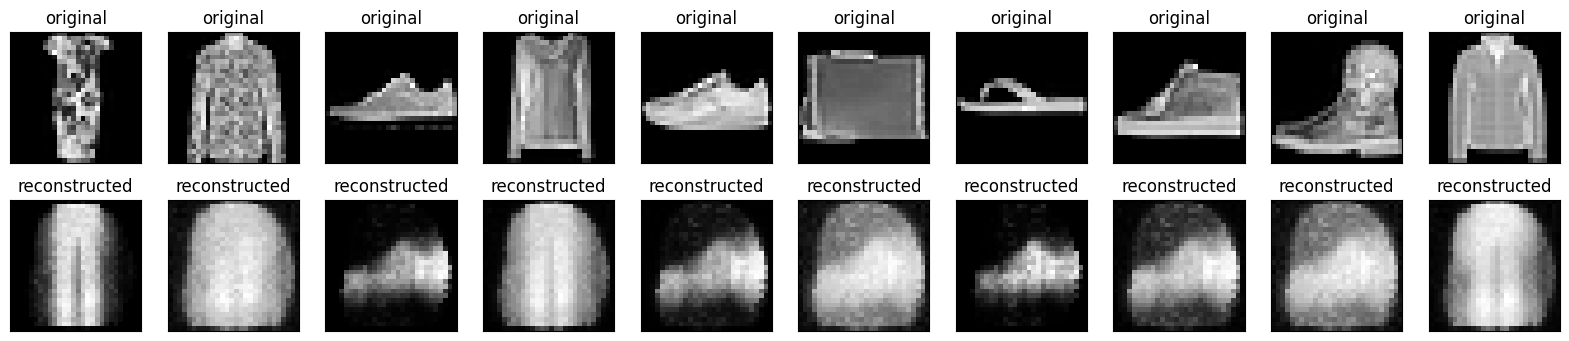

In [103]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i+100])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i+100])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [70]:
latent_dim=64
enc = encoder(latent_dim)
dec = decoder(latent_dim)


# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
 
    with tf.GradientTape() as encoder_grad, tf.GradientTape() as decoder_grad:
       
        mean, log_var = enc(images, training=True)
        latent = sampling(mean, log_var)
        generated_images = dec(latent, training=True)
        loss = vae_loss(images, generated_images, mean, log_var)
 
         
    gradients_of_enc = encoder_grad.gradient(loss, enc.trainable_variables)
    gradients_of_dec = decoder_grad.gradient(loss, dec.trainable_variables)
     
     
    optimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
    return loss

In [33]:
import time

In [81]:
x_train.shape

(60000, 28, 28)

In [54]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    train_step(dataset)
 
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
 
 
train(x_train, epochs=10)

OperatorNotAllowedInGraphError: in user code:

    File "/var/folders/hc/mx19r91j1ms05m9rf9bljc980000gn/T/ipykernel_64075/4143613019.py", line 13, in train_step  *
        latent = sampling(mean, log_var)
    File "/var/folders/hc/mx19r91j1ms05m9rf9bljc980000gn/T/ipykernel_64075/2707293834.py", line 13, in sampling  *
        mean = layers.Input(shape=mean, name='input_layer1')
    File "/Users/zequnz/Library/Caches/pypoetry/virtualenvs/experiment-playground-MSoUyc0e-py3.11/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py", line 191, in Input  **
        layer = InputLayer(
    File "/Users/zequnz/Library/Caches/pypoetry/virtualenvs/experiment-playground-MSoUyc0e-py3.11/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py", line 92, in __init__
        shape = backend.standardize_shape(shape)
    File "/Users/zequnz/Library/Caches/pypoetry/virtualenvs/experiment-playground-MSoUyc0e-py3.11/lib/python3.11/site-packages/keras/src/backend/common/variables.py", line 550, in standardize_shape
        shape = tuple(shape)

    OperatorNotAllowedInGraphError: Iterating over a symbolic `tf.Tensor` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information.


InvalidArgumentError: {{function_node __wrapped__Sub_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [60000,28,28] vs. [60000,28,28,1] [Op:Sub] name: 